## Modules à importer

In [1]:
import math
import glob
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
from snprop import age
from scipy import stats
from pymage import query
from astropy import units
from variaIa import tools as Iatools
from snprop import survey, tools
from variaIa.tools import surveys, df_cons, df_nc, df_c, df_full
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.cosmology import Planck15 as Planck15
from scipy.interpolate import interp2d as spline
from matplotlib.lines import Line2D
from pprint import PrettyPrinter
from variaIa import stretchevol
from variaIa import massevol
from importlib import reload

## Définitions pandas, surveys et sélection de l'échantillon à utiliser

In [2]:
def set_survey(cons, su):
    global df
    if su == 'All':
        df = df_cons(cons)
    elif 'n' in su:
        df = df_cons(cons)[df_cons(cons)['survey'] != su.split('n')[-1]]
    else:
        df = df_cons(cons)[df_cons(cons)['survey'] == su]
    return df

int_set_su = ipw.interactive(set_survey, cons=Iatools.cons, su=Iatools.su)
display(int_set_su)

smap = plt.cm.get_cmap('cividis')
#smap = plt.cm.get_cmap('viridis')
colors = {'SNF': plt.cm.binary(0.9),
          'low-z': (1, 0, 0),
          'SDSS': smap(0.1),
          'PS1': smap(0.5),
          'SNLS': smap(0.8),
          'HST': smap(0.99),  # for cividis
          #'HST': smap(300),  # for viridis
          'All': (255/255, 51/255, 0/255)} 

def alphacolors(alpha, survey):
    return(colors[survey][0], colors[survey][1], colors[survey][2], alpha)

df_nHST = df_nc[df_nc['survey'] != 'HST']
df_nlowz = df_nc[df_nc['survey'] != 'low-z']
df_full_data = df_full[~df_full['survey'].isin(['SNF', 'HST'])]

interactive(children=(Checkbox(value=False, description='Conservative'), Dropdown(description='Survey:', optio…

## Second `SNANA` implementation: with HOSTLIB magshift=0.70

### Choose simu

In [182]:
sim_path = glob.glob("../../../Data/sims/NN*")
sc = ipw.Dropdown(options=sim_path,
                  description='Sim choice',
                  value=sim_path[0])

bias = ipw.Checkbox(description='Bias Cor?', value=True)

def set_fitprop(path):
    global fitprop_data
    if len(glob.glob(path + '/fitprop_data')) == 0:
        fitprop_data = []
    else:
        with open(path + '/fitprop_data', 'rb') as f:
            fitprop_data = pickle.load(f)

int_set_fitprop = ipw.interactive(set_fitprop, path=sc)
display(int_set_fitprop, bias)

interactive(children=(Dropdown(description='Sim choice', options=('../../../Data/sims/NN_G10_PANTH-MSK66-BP_V5…

Checkbox(value=True, description='Bias Cor?')

### Load selected

In [9]:
fitres_list = glob.glob(sc.value + '/FIT*.FITRES')
fitres_list

['../../../Data/sims/NN_G10_PANTH-MSK66-BP_V4/FITOPT000_MUOPT002.FITRES',
 '../../../Data/sims/NN_G10_PANTH-MSK66-BP_V4/FITOPT001_MUOPT000.FITRES',
 '../../../Data/sims/NN_G10_PANTH-MSK66-BP_V4/FITOPT000_MUOPT001.FITRES',
 '../../../Data/sims/NN_G10_PANTH-MSK66-BP_V4/FITOPT000_MUOPT000.FITRES',
 '../../../Data/sims/NN_G10_PANTH-MSK66-BP_V4/FITOPT002_MUOPT000.FITRES',
 '../../../Data/sims/NN_G10_PANTH-MSK66-BP_V4/FITOPT001_MUOPT004.FITRES']

In [10]:
fitres = tools.Checker.read(fitres_list[3])

### Sample sims to data

In [11]:
fitres_data = tools.Checker.sample_sims(fitres, df_full_data)

#### Just to check

In [16]:
surveys_size = {survey: len(df_full[df_full['survey'] == survey])
                for survey in ['low-z', 'SDSS', 'PS1', 'SNLS']}

fitres_size = {survey: len(fitres[fitres['IDSURVEY'].isin(idsurvey)])
                 for survey, idsurvey in zip(['low-z', 'SDSS', 'PS1', 'SNLS'],
                                             [[5, 64, 65, 66], [1], [15], [4]])}

fitres_data_size = {survey: len(fitres_data[fitres_data['IDSURVEY'].isin(idsurvey)])
                     for survey, idsurvey in zip(['low-z', 'SDSS', 'PS1', 'SNLS'],
                                             [[5, 64, 65, 66], [1], [15], [4]])}

In [25]:
print('surveys_size =\t\t', surveys_size)
print('fitres_size =\t\t', fitres_size)
print('fitres_data_size =\t', fitres_data_size)

print('low-z ratio in data =', surveys_size['low-z']/surveys_size['low-z'])
print(' SDSS ratio in data =', surveys_size['SDSS']/surveys_size['low-z'])
print('  PS1 ratio in data =', surveys_size['PS1']/surveys_size['low-z'])
print(' SNLS ratio in data =', surveys_size['SNLS']/surveys_size['low-z'])

print('low-z ratio in uncut sims =', fitres_size['low-z']/fitres_size['low-z'])
print(' SDSS ratio in uncut sims =', fitres_size['SDSS']/fitres_size['low-z'])
print('  PS1 ratio in uncut sims =', fitres_size['PS1']/fitres_size['low-z'])
print(' SNLS ratio in uncut sims =', fitres_size['SNLS']/fitres_size['low-z'])

print('low-z ratio in cut sims =', fitres_data_size['low-z']/fitres_data_size['low-z'])
print(' SDSS ratio in cut sims =', fitres_data_size['SDSS']/fitres_data_size['low-z'])
print('  PS1 ratio in cut sims =', fitres_data_size['PS1']/fitres_data_size['low-z'])
print(' SNLS ratio in cut sims =', fitres_data_size['SNLS']/fitres_data_size['low-z'])

### Save cut and sampled data

In [144]:
pickle.dump(fitres_data, open(sc.value + '/fitres_data', 'wb'))

In [6]:
with open(sc.value + '/fitres_data', 'rb') as f:
    fitres_data = pickle.load(f)

### Now plot!

In [4]:
num_list = tools.Checker.get_numbers(sc.value)
np.asarray(num_list)

array([['000', '000'],
       ['000', '001'],
       ['000', '002'],
       ['001', '000'],
       ['001', '004'],
       ['002', '000']], dtype='<U3')

In [186]:
checkit = tools.Checker(sc.value,
                        df_full_data)

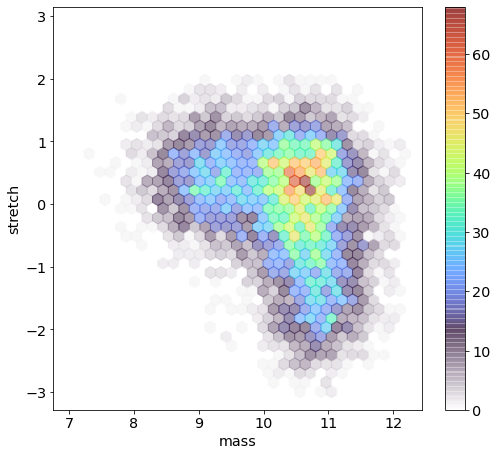

In [187]:
checkit.show_scatter('mass', 'stretch', alpha_data=0)

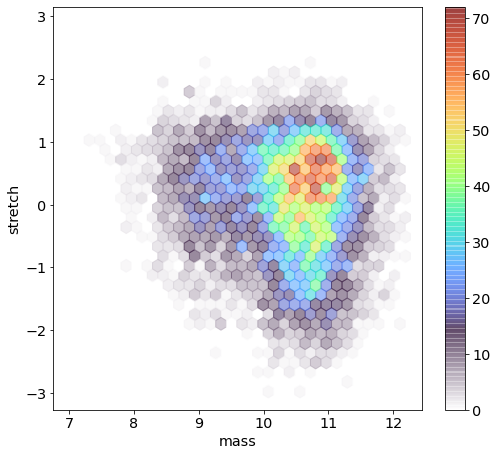

In [185]:
checkit.show_scatter('mass', 'stretch', alpha_data=0)

In [6]:
checkit.set_kernel('mass', 'stretch', True)
checkit.set_kernel('redshift', 'stretch', True)

In [7]:
checkit.fit('mass_stretch')
checkit.fit('redshift_stretch')

441.43314353010044

In [120]:
checkit.kernels

{'mass_stretch': <scipy.stats.kde.gaussian_kde at 0x7f624d8a6810>,
 'redshift_stretch': <scipy.stats.kde.gaussian_kde at 0x7f624d7f2ed0>}

In [121]:
checkit.fits

{'mass_stretch': 95.12256840338576, 'redshift_stretch': 441.5566863390428}

In [118]:
pickle.dump(checkit, open(sc.value + '/checkit', 'wb'))

In [119]:
with open(sc.value + '/checkit', 'rb') as f:
    checkit = pickle.load(f)

In [157]:
checkit.wfit

,w,w_sig,omm,omm_sig,chi2,sigint,wrand,ommrand,label
1,-1.0645,0.0279,0.3125,0.0088,31.2,0.0080,0.0000,0.0000,none


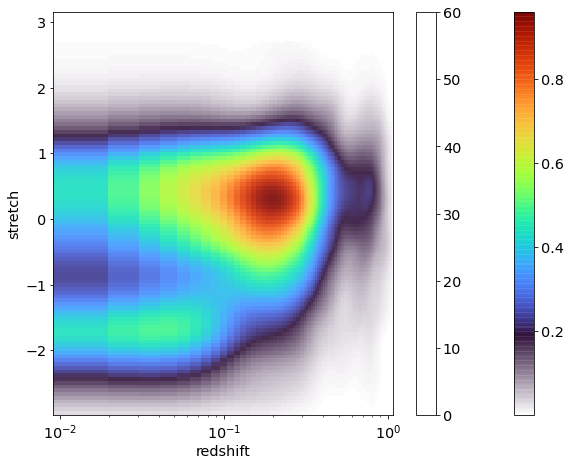

In [90]:
fig = plt.figure(figsize=[10, 7])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

#ax = checkit.show_kernel(kernel=kernel,
#                         abs_name='redshift', ord_name='stretch',
#                         aspect=.8, alpha_kernel=.50)

checkit.show_kernel('redshift_stretch', ax=ax,
                    aspect=.4, alpha_kernel=.90)

ax.set_xscale('log')

checkit.show_scatter('redshift', 'stretch', ax=ax,
                     gsize=40,
                     #xsimscale='log', #cmap='inferno',
                     alpha_sims=0.0, show_cb=True, alpha_data=0.0)

### HR plots

In [180]:
Planck15.name

'Planck15'

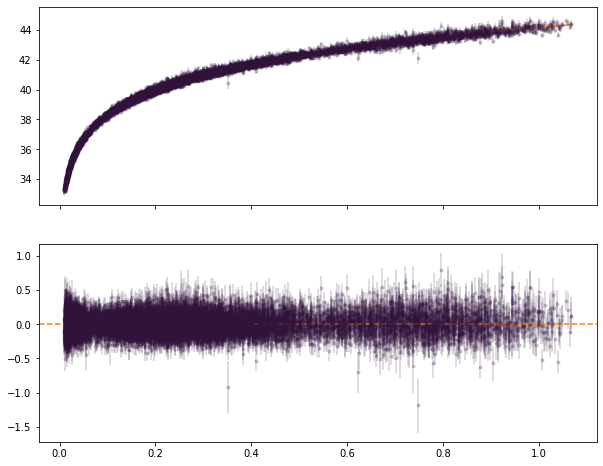

In [181]:
fig, (ax1, ax2) = plt.subplots(2, 1,
                               figsize=[10,8], sharex=True)

ax1.errorbar(fitres_data.zCMB, fitres_data.MU,
             xerr=fitres_data.zCMBERR, yerr=fitres_data.MUERR,
             fmt='.', alpha=.2, color=tools.cmap_tpw(0.2),
             label='Fitres data')

z_lin = np.linspace(np.min(fitres_data['zCMB']),
                    np.max(fitres_data['zCMB']),
                    1000)
mu_cosmo = Planck15.distmod(z_lin)/units.mag

ax1.plot(z_lin, mu_cosmo,
         color='C1', label='Planck15')

ax2.errorbar(fitres_data.zCMB, fitres_data.MURES,
             xerr=fitres_data.zCMBERR, yerr=fitres_data.MUERR,
             fmt='.', alpha=.2, color=tools.cmap_tpw(0.2))
ax2.axhline(0, ls='--', color='C1')

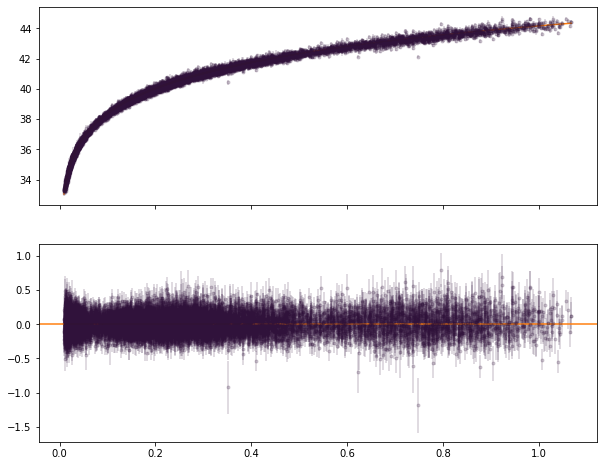

In [176]:
fig = plt.figure(figsize=[10, 7])
ax1 = fig.add_axes([0.1, 0.12, 0.8, 0.8])
ax2 = fig.add_axes([])

ax1.errorbar(fitres_data.zCMB, fitres_data.MU,
             xerr=fitres_data.zCMBERR, yerr=fitprop_data.MUERR,
             fmt='.', alpha=.2, color=tools.cmap_tpw(0.2),
             label='Fitres data')

z_lin = np.linspace(np.min(fitres_data['zCMB']),
                    np.max(fitres_data['zCMB']),
                    1000)
mu_cosmo = Planck15.distmod(z_lin)/units.mag

ax1.plot(z_lin, mu_cosmo,
         color='C1', label='Planck15')

ax2.errorbar(fitres_data.zCMB, fitres_data.MURES,
             xerr=fitres_data.zCMBERR, yerr=fitres_data.MUERR,
             fmt='.', alpha=.2, color=tools.cmap_tpw(0.2))
ax2.axhline(0, color='C1')

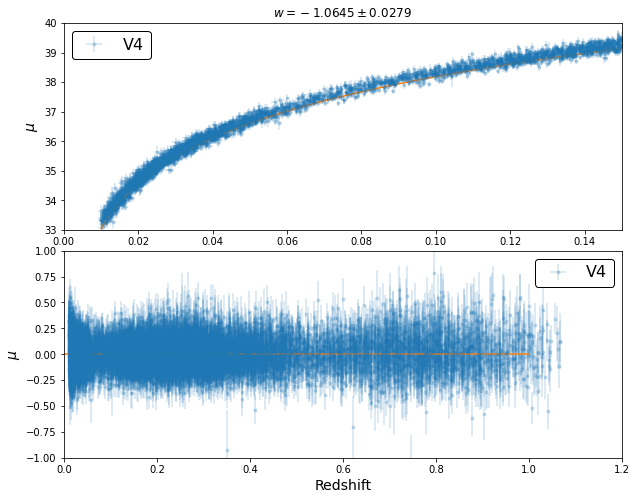

In [165]:
fig = plt.figure(figsize=[10,8])
widths = [1]
heights = [1,1]
spec5 = fig.add_gridspec(ncols=1, nrows=2,
                         width_ratios=widths, height_ratios=heights,
                         wspace=0.1, hspace=0.1)
ax1 = fig.add_subplot(spec5[0, 0])

# alpha=0.14
# beta = 3.1
# M = -19

theory = Planck15.distmod(fitprop_data.zHD)/units.mag-0.2
dummy_z = [x*0.001+0.01 for x in range(0, 1200)]
dummy_theory = Planck15.distmod(dummy_z)/units.mag-0.2
#ax1.errorbar(fitprop_data.redshift, -2.5*np.log10(fitprop_data.x0)+10.653+alpha*fitprop_data.x1-beta*fitprop_data.c-M, fmt='.', label='Y1: fitprop_data')
ax1.errorbar(fitprop_data.zHD, fitprop_data.MU,
             xerr=fitprop_data.zHDERR, yerr=fitprop_data.MUERR,
             fmt='.', alpha=.2,
             label=sc.value[-2:])
ax1.plot(dummy_z, dummy_theory)
#ax1.errorbar(fitprop_data_consz.redshift, fitprop_data_consz.x1, yerr=fitprop_data_consz.x1_err, fmt='.', alpha=0.5, label='Y1: z<0.075')
ax1.set_xlim(0.0,0.15)
ax1.set_ylim(33,40)
ax1.set_xlabel('Redshift',size=14)
ax1.set_ylabel(r'$\mu$',size=14)
ax1.legend(prop={'size': 16}, fancybox=True,
           framealpha=1.0, edgecolor='black')
ax1.set_title(r'$w = -1.0645\pm0.0279$')

ax1 = fig.add_subplot(spec5[1, 0])
#
alpha=0.14
beta = 3.1
M = -19
theory = Planck15.distmod(fitprop_data.zHD)/units.mag-0.2
dummy_z = [x*0.001+0.01 for x in range(0, 1200)]
dummy_theory = Planck15.distmod(dummy_z)/units.mag-0.2
ax1.errorbar(fitprop_data.zHD, fitprop_data.MURES,
             xerr=fitprop_data.zHDERR, yerr=fitprop_data.MUERR,
             fmt='.', alpha=.2,
             label=sc.value[-2:])

ax1.plot([0,1],[0,0])
ax1.set_xlim(0.0,1.2)
ax1.set_ylim(-1,1)
ax1.set_xlabel('Redshift',size=14)
ax1.set_ylabel(r'$\mu$',size=14)
ax1.legend(prop={'size': 16}, fancybox=True,
           framealpha=1.0, edgecolor='black')

In [53]:
def kernel_toint(x, y):
    return checkit.kernels['mass_stretch']([x, y])
scipy.integrate.dblquad(kernel_toint,
                        checkit.kernels['mass_stretch'].dataset[0].min(), checkit.kernels['mass_stretch'].dataset[0].max(),
                        checkit.kernels['mass_stretch'].dataset[1].min(), checkit.kernels['mass_stretch'].dataset[1].max())

(0.0, 0)

In [55]:
scipy.integrate.dblquad(kernel_toint,
                        10, 11,
                        lambda x: -1, lambda x: 1)

(0.0, 0)

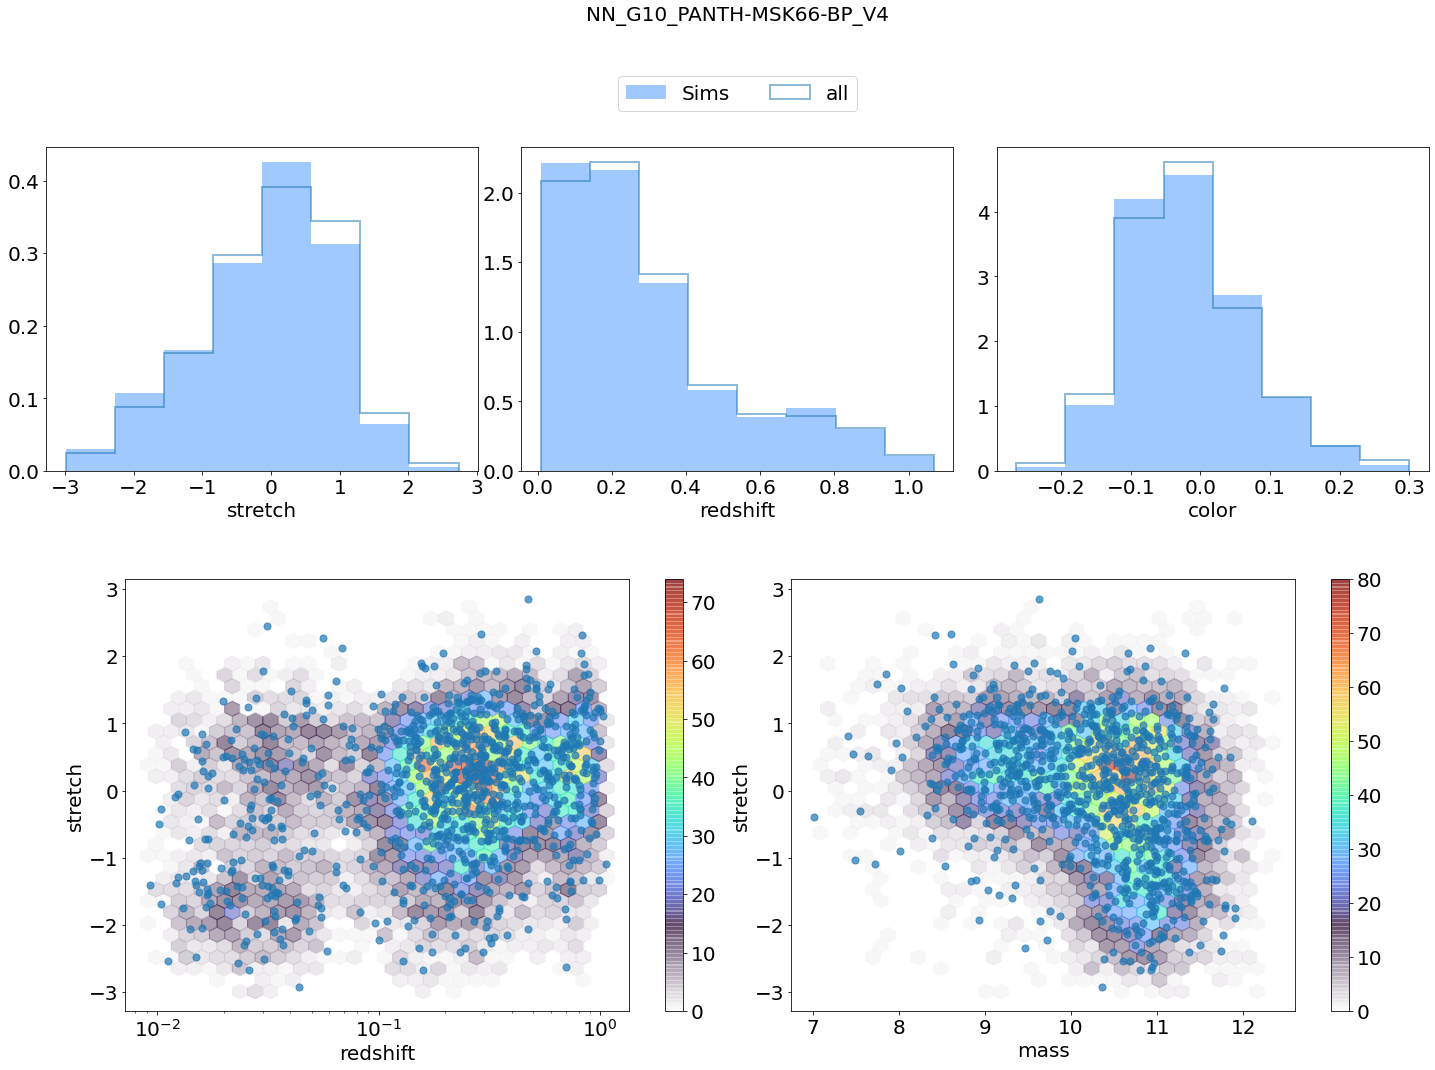

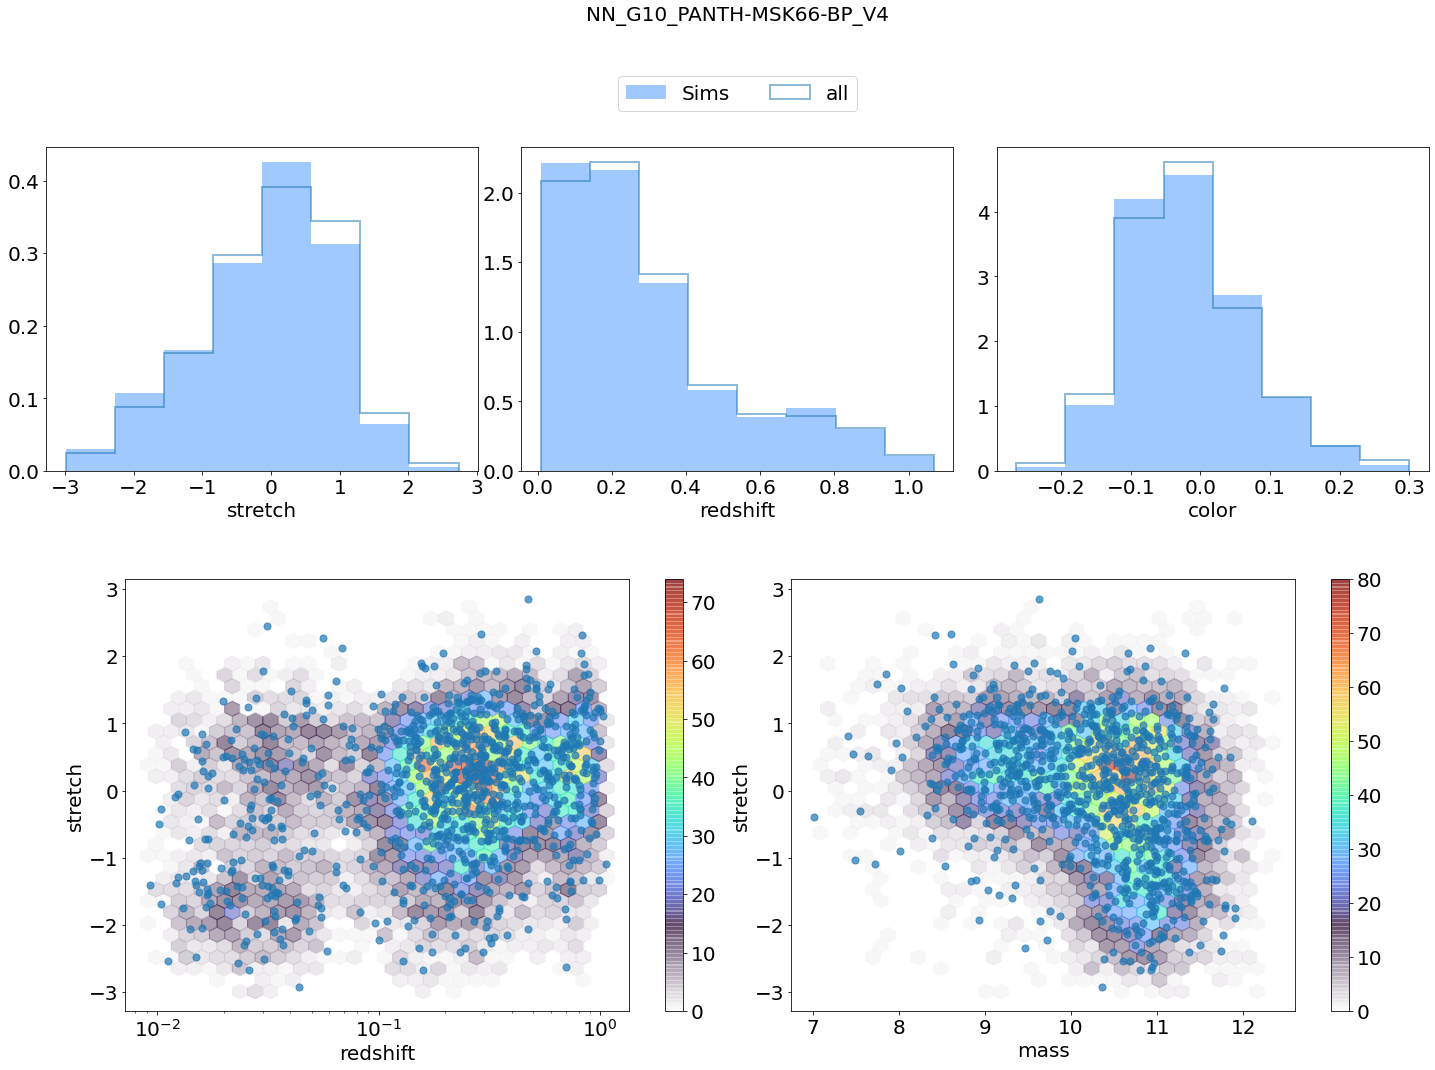

In [132]:
checkit.show_all()

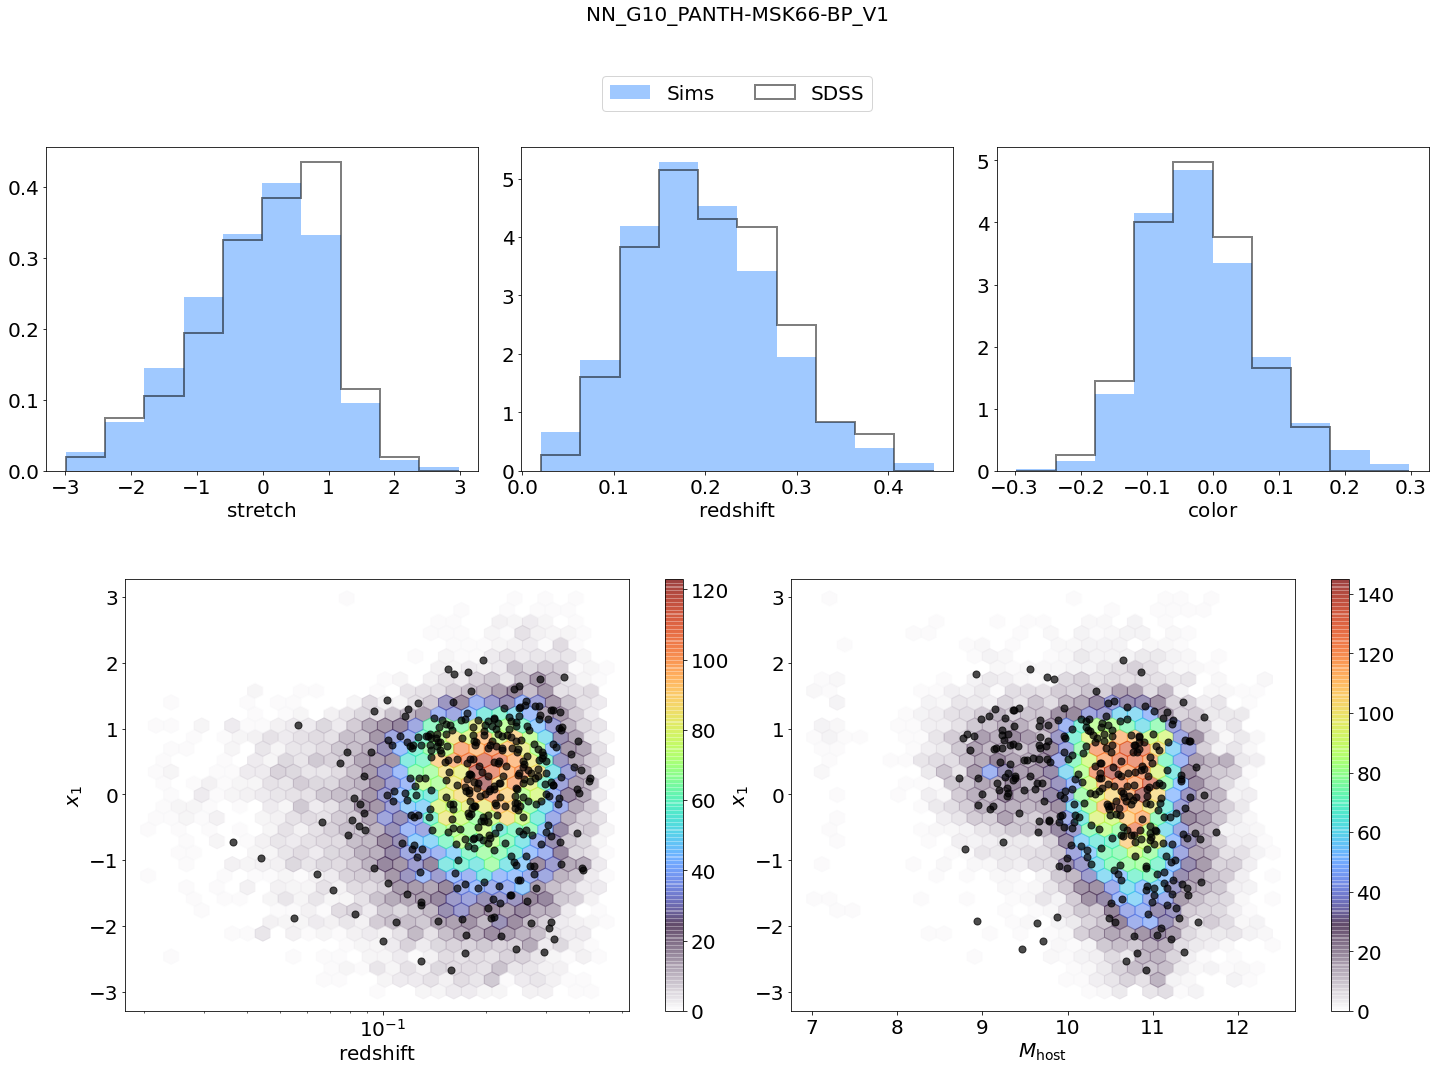

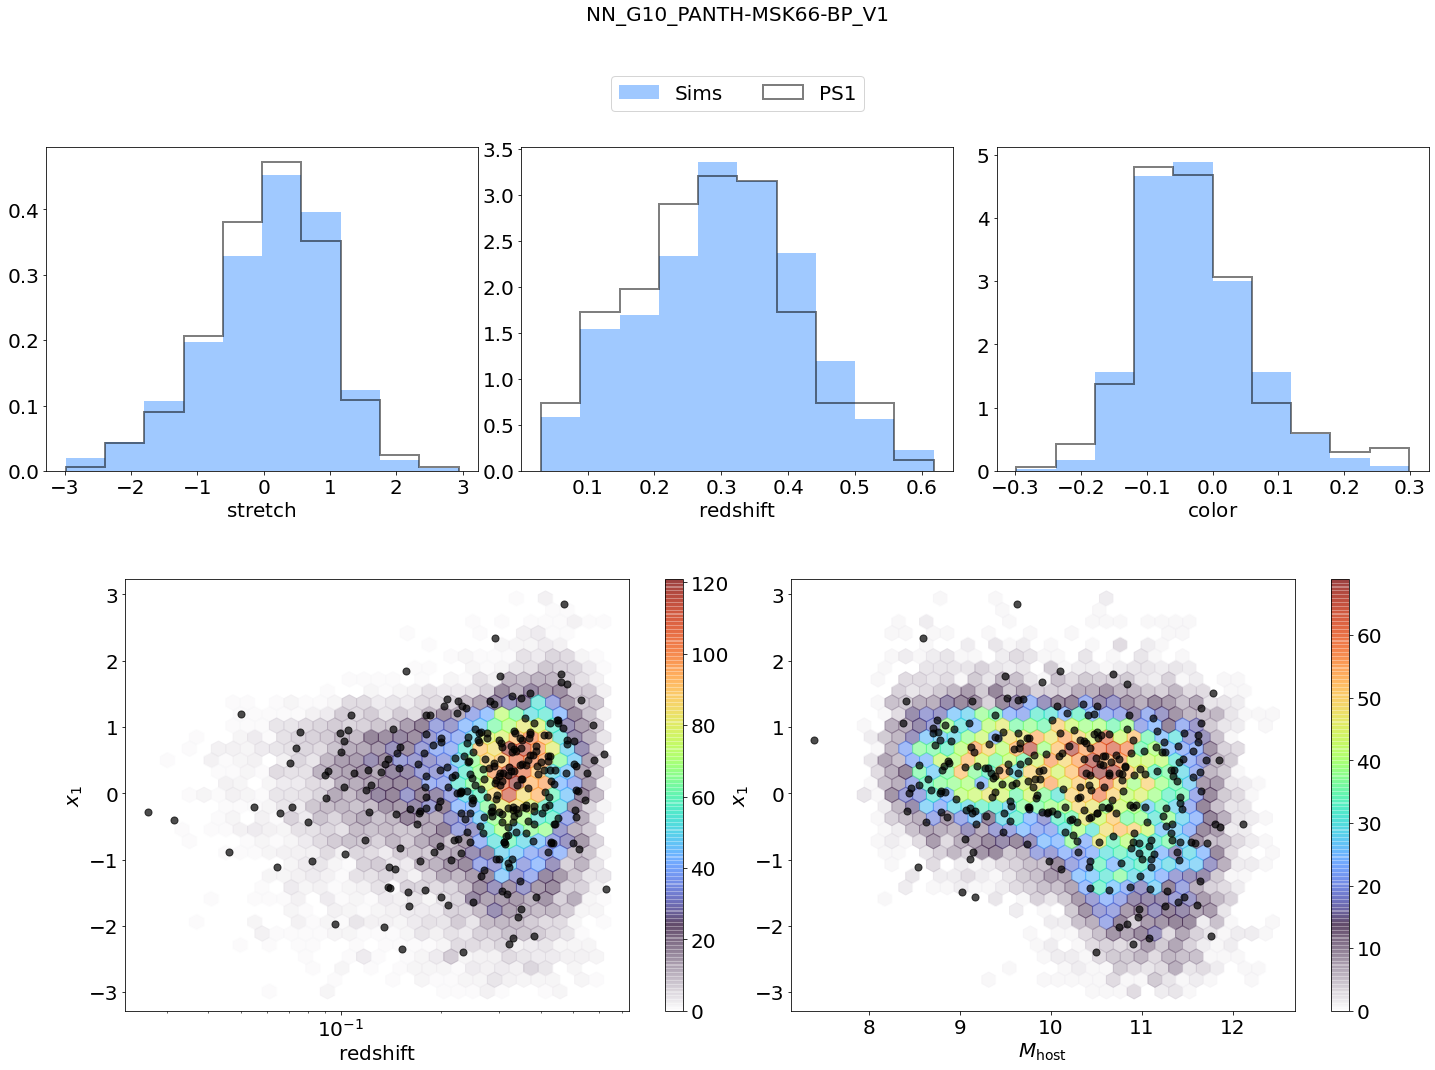

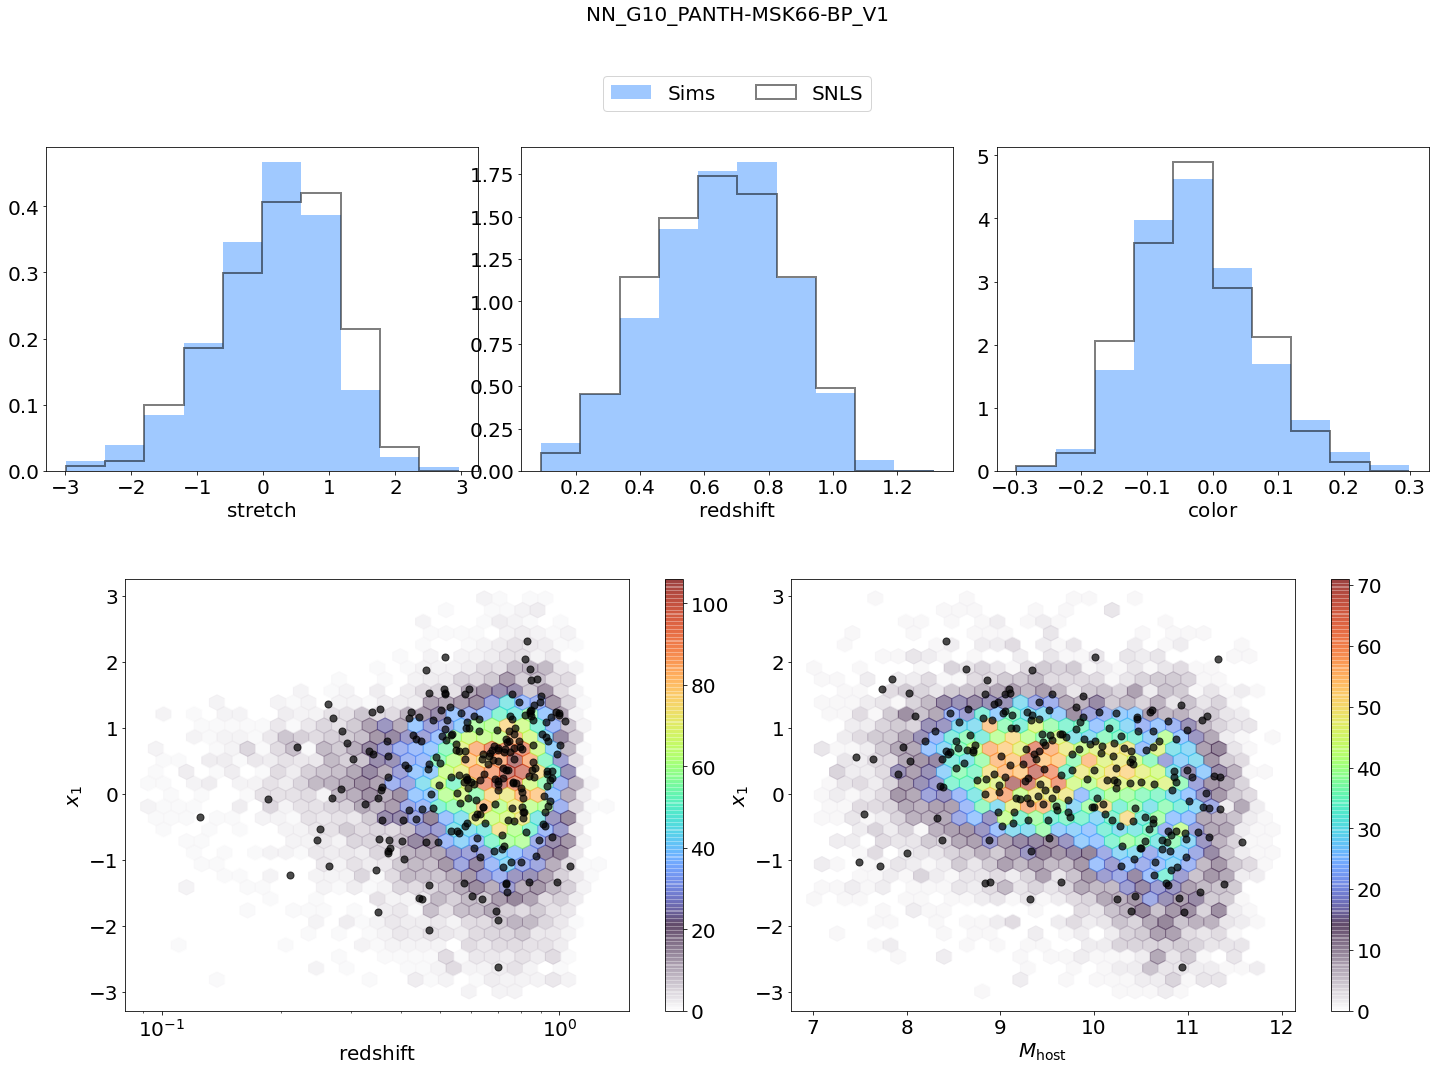

In [7]:
width_plot_cb = 0.35
space_cb = 0.025
width_cb = 0.0125
xmin_bottom = 0.075
ymin_bottom = 0.05
height_plot_cb = 0.40

xmin_top = 0.02
ymin_top = 0.15 + height_plot_cb
width_plot = 0.30
space_plot = 0.03
height_plot = 0.30

for i, zipped in enumerate(zip(surveys[1:-1], [1, 15, 4])):
    survey = zipped[0]
    idsurvey = zipped[-1]
    fig = plt.figure(figsize=[20, 15])
    
    ax4 = fig.add_axes([xmin_top, ymin_top,
                        width_plot, height_plot])
    
    ax1 = fig.add_axes([ax4.get_position().get_points()[1][0]
                        + space_plot, ymin_top,
                        width_plot, height_plot])
    
    ax5 = fig.add_axes([ax1.get_position().get_points()[1][0]
                        + space_plot, ymin_top,
                        width_plot, height_plot])
    
    ax2 = fig.add_axes([xmin_bottom, ymin_bottom,
                        width_plot_cb, height_plot_cb])
    axb = fig.add_axes([ax2.get_position().get_points()[1][0]
                        + space_cb, ymin_bottom,
                        width_cb, height_plot_cb])
    
    ax3 = fig.add_axes([axb.get_position().get_points()[1][0]
                        + 3*space_cb, ymin_bottom,
                        width_plot_cb, height_plot_cb])
    axc = fig.add_axes([ax3.get_position().get_points()[1][0]
                        + space_cb, ymin_bottom,
                        width_cb, height_plot_cb])
    
    df_full_data_used = df_full[df_full['survey'] == survey]
    fitprop_data_used = fitprop_data[fitprop_data['IDSURVEY'] == idsurvey]
    
    color_data = 'k'
    
    #############################################################################
    
    prophist = dict(alpha=.5, density=True)
    
    _, bins, _ = ax1.hist(fitprop_data_used.zCMB,
                          histtype='stepfilled',
                          facecolor=tools.cmap_tpw(0.35),
                          edgecolor=None,
                          label='Sims',
                          **prophist)
    
    ax1.hist(df_full_data_used.redshifts,
             bins=bins,
             histtype='step', lw=2,
             color=color_data,
             label=survey,
             **prophist)
    
    _, bins, _ = ax4.hist(fitprop_data_used.x1,
                          histtype='stepfilled',
                          facecolor=tools.cmap_tpw(0.35),
                          edgecolor=None,
                          label='Sims',
                          **prophist)
    
    ax4.hist(df_full_data_used.stretchs,
             bins=bins,
             histtype='step', lw=2,
             color=color_data,
             label=survey,
             **prophist)
    
    
    _, bins, _ = ax5.hist(fitprop_data_used.c,
                          histtype='stepfilled',
                          facecolor=tools.cmap_tpw(0.35),
                          edgecolor=None,
                          label='Sims',
                          **prophist)
    
    ax5.hist(df_full_data_used.colors,
             bins=bins,
             histtype='step', lw=2,
             color=color_data,
             label=survey,
             **prophist)
    
    #############################################################################
    
    prop2d = dict(alpha=.5, gridsize=30, cmap=tools.cmap_tpw)
    
    
    hb2 = ax2.hexbin(fitprop_data_used.zCMB,
                     fitprop_data_used.x1,
                     xscale='log',
                     **prop2d)
    ax2.set_xscale('log')
    
    cb2 = fig.colorbar(hb2, cax=axb)
    
    prop = dict(marker="o", s=50, lw=1, alpha=.7, color=color_data)
    
    ax2.scatter(df_full_data_used.redshifts,
                df_full_data_used.stretchs,
                label=survey, **prop)
    
    #############################################################################
    
    fitprop_data_used_mass7 = fitprop_data_used[fitprop_data_used['HOST_LOGMASS'] > 7]
    df_full_data_used_mass7 = df_full_data_used[df_full_data_used['hostmass'] > 7]
    
    hb3 = ax3.hexbin(fitprop_data_used_mass7.HOST_LOGMASS,
                     fitprop_data_used_mass7.x1,
                     **prop2d)
    
    cb3 = fig.colorbar(hb3, cax=axc)
    
    ax3.scatter(df_full_data_used_mass7.hostmass,
                df_full_data_used_mass7.stretchs,
                label=survey, **prop)
    #############################################################################
    
    ax1.tick_params(labelsize=20)
    ax4.tick_params(labelsize=20)
    ax5.tick_params(labelsize=20)
    ax2.tick_params(labelsize=20)
    cb2.ax.tick_params(labelsize=20)
    ax3.tick_params(labelsize=20)
    cb3.ax.tick_params(labelsize=20)
    
    ax1.set_xlabel(r"$\mathrm{redshift}$ ", fontsize=20)
    #ax1.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize=20)
    
    ax4.set_xlabel(r"$\mathrm{stretch}$ ", fontsize=20)
    #ax4.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize=20)
    
    ax5.set_xlabel(r"$\mathrm{color}$ ", fontsize=20)
    #ax5.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize=20)
    
    ax2.set_xlabel(r"$\mathrm{redshift}$ ", fontsize=20)
    ax2.set_ylabel(r"$x_1$", fontsize=20)
    #cb2.set_label('counts', fontsize=20)
    
    ax3.set_xlabel(r"$M_\mathrm{host}$ ", fontsize=20)
    ax3.set_ylabel(r"$x_1$", fontsize=20)
    #cb3.set_label('counts', fontsize=20)
    
    ax1.legend(fontsize=20, ncol=2,
               loc='upper center',
               bbox_to_anchor=(0.5, 1.0, 0.0, 0.25))
    
    fig.suptitle(sc.value.split('/')[-1], fontsize=20)
    
    #fig.savefig('../../../Images/pdf/fitprop_data_' + sc.value.split('/')[-1]
    #            + '_' + survey + '.pdf',
    #            bbox_inches='tight')
    #fig.savefig('../../../Images/png/fitprop_data_' + sc.value.split('/')[-1]
    #            + '_' + survey + '.png',
    #            bbox_inches='tight', transparent=False)

## `age` module testing

In [2]:
pdmodel = age.PrompDelayModel()
pdmodel.draw_sample(z=0.04, size=1000)

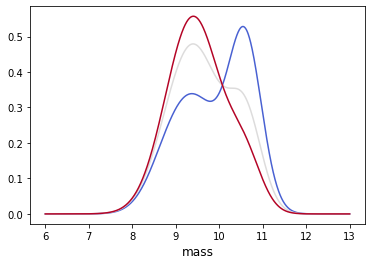

In [6]:
fig = pdmodel.show_pdf("mass", z=[0.05, 0.5, 1], zmax=1)

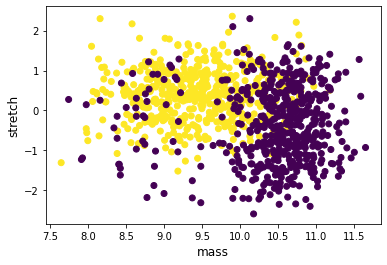

In [13]:
fig = pdmodel.show_scatter("mass","stretch", colorkey="age")

## Fit mass Brodie

In [4]:
with open('../../../Data/sne/lowz_df', 'rb') as f:
    lowz_df = pickle.load(f)

In [50]:
lowz_df['hg_masserr_nr'] = np.sqrt((lowz_df['hg_masserr_nr_down']**2
                                    + lowz_df['hg_masserr_nr_up']**2)/2)

In [51]:
lowz_df_fit = lowz_df.copy()
lowz_df_fit

In [46]:
lowz_df_fit.rename(columns={'zcmb': 'redshifts',
                            'hg_mass_nr': 'hostmass';
                            'hg_masserr_nr': 'hostmass_err'})

,CID,ra,dec,zcmb,hg_mass_sco,hg_masserr_sco,hg_mass_nr,hg_masserr_nr_down,hg_masserr_nr_up
0,2001ah,167.624,55.1608,0.05891,11.141,0.02,11.733746,0.100610,0.102540
1,2001az,248.614,76.0295,0.04059,11.376,0.059,11.563016,0.098809,0.099862
2,2001da,358.386,8.11728,0.01647,11.006,0.042,11.246402,0.100754,0.099997
3,2001en,21.3452,34.025,0.01544,11.133,0.078,11.390831,0.098434,0.100087
4,2001fe,144.488,25.4947,0.01449,10.277,0.095,11.013707,0.100463,0.099176
...,...,...,...,...,...,...,...,...,...
165,2000B,106.417,50.5888,0.02045,11.44,2.78,12.175438,0.098304,0.098759
166,2000cf,238.248,65.9378,0.03646,10.1732,0.2809,10.743448,0.098631,0.099377
167,2000cn,269.425,27.8257,0.02321,10.9619,0.2809,11.172982,0.100555,0.099259
168,2000dk,16.8446,32.4111,0.01602,10.4766,0.3742,12.195576,0.099497,0.099416


In [64]:
base_model = massevol.Evol3G3M3S(df)
base_model.minimize(limit_a=(0,1))
print(base_model.param)

{'mu_1': 9.42435033203514, 'sigma_1': 0.6352164641545026, 'a': 0.902710356796472, 'mu_2': 10.59321817727873, 'sigma_2': 0.3739487056160915, 'mu_3': 8.74496390066, 'sigma_3': 0.42788950723936164}


In [63]:
with open('../../../Data/mass/snf_mass', 'rb') as f:
    snf_mass = pickle.load(f)

No handles with labels found to put in legend.
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in log
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in log


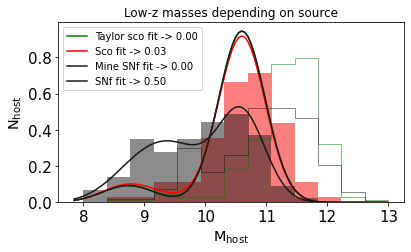

In [67]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])

prop_hist = dict(bins=13, range=[8, 13], alpha=.5, density=True)

lowz_df_nr_sup8 = lowz_df[lowz_df['hg_mass_nr'] > 8]
ax.hist(lowz_df_nr_sup8['hg_mass_nr'],
        histtype='step',
        color='g',
        **prop_hist)

lowz_df_sco_sup8 = lowz_df[lowz_df['hg_mass_sco'] > 8]
ax.hist(lowz_df_sco_sup8['hg_mass_sco'],
        color=colors['low-z'],
        **prop_hist)

ax.hist(snf_mass[:, 0],
        color=colors['SNF'],
        **prop_hist,
        histtype='step')

ax.hist(df['hostmass'],
        color=colors['SNF'],
        **prop_hist)

ax.tick_params(labelsize=15)

ax.set_xlabel(r"$\mathrm{M}_\mathrm{host}$", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{N}_\mathrm{host}$", fontsize="x-large")

ax.legend(loc='upper left')

plt.title('Low-z masses depending on source')

def pdf_mass(x, fprompt):
    prompt_pdf = scipy.stats.norm.pdf(x,
                                      loc=9.41,
                                      scale=0.62)

    delay_pdf1 = scipy.stats.norm.pdf(x,
                                      loc=10.60,
                                      scale=0.38)

    delay_pdf2 = scipy.stats.norm.pdf(x,
                                      loc=8.74,
                                      scale=0.43)

    return(fprompt * prompt_pdf +
           (1-fprompt) * (0.90*delay_pdf1 + (1-0.90)*delay_pdf2))

def loglikepdf_mass_nr(fprompt):
    return -2*np.sum(np.log(pdf_mass(lowz_df_nr_sup8['hg_mass_nr'], fprompt)))

hg_sco_nparray = [lowz_df_sco_sup8['hg_mass_sco'].values[i]
                  for i in range(len(lowz_df_sco_sup8))]
def loglikepdf_mass_sco(fprompt):
    return -2*np.sum(np.log(pdf_mass(hg_sco_nparray, fprompt)))

def loglikepdf_mass_snf_mine(fprompt):
    return -2*np.sum(np.log(pdf_mass(snf_mass[:, 0], fprompt)))

def loglikepdf_mass_snf(fprompt):
    return -2*np.sum(np.log(pdf_mass(df['hostmass'], fprompt)))

def minimize_pdf_mass_nr(print_level=0, **kwargs):
    '''Renvoie la meilleure valeur des paramètres'''
    m_tot = im.Minuit(loglikepdf_mass_nr,
                      print_level=print_level,
                      pedantic=False,
                      **kwargs)
    migrad_out = m_tot.migrad()
    return(m_tot)

def minimize_pdf_mass_sco(print_level=0, **kwargs):
    '''Renvoie la meilleure valeur des paramètres'''
    m_tot = im.Minuit(loglikepdf_mass_sco,
                      print_level=print_level,
                      pedantic=False,
                      **kwargs)
    migrad_out = m_tot.migrad()
    return(m_tot)

def minimize_pdf_mass_snf_mine(print_level=0, **kwargs):
    '''Renvoie la meilleure valeur des paramètres'''
    m_tot = im.Minuit(loglikepdf_mass_snf_mine,
                      print_level=print_level,
                      pedantic=False,
                      **kwargs)
    migrad_out = m_tot.migrad()
    return(m_tot)

def minimize_pdf_mass_snf(print_level=0, **kwargs):
    '''Renvoie la meilleure valeur des paramètres'''
    m_tot = im.Minuit(loglikepdf_mass_snf,
                      print_level=print_level,
                      pedantic=False,
                      **kwargs)
    migrad_out = m_tot.migrad()
    return(m_tot)

bestfit_mass_nr = minimize_pdf_mass_nr().values['fprompt']
bestfit_mass_sco = minimize_pdf_mass_sco().values['fprompt']
bestfit_mass_snf_mine = minimize_pdf_mass_snf_mine().values['fprompt']
bestfit_mass_snf = minimize_pdf_mass_snf().values['fprompt']

xlin = np.linspace(7.85, 12.98, 100)
ax.plot(xlin,
        pdf_mass(xlin, bestfit_mass_nr),
        color='g',
        label=f'Taylor sco fit -> {bestfit_mass_nr:.2f}')
ax.plot(xlin,
        pdf_mass(xlin, bestfit_mass_sco),
        color=colors['low-z'],
        label=f'Sco fit -> {bestfit_mass_sco:.2f}')
ax.plot(xlin,
        pdf_mass(xlin, bestfit_mass_snf_mine),
        color=colors['SNF'],
        label=f'Mine SNf fit -> {bestfit_mass_snf_mine:.2f}')
ax.plot(xlin,
        pdf_mass(xlin, bestfit_mass_snf),
        color=colors['SNF'],
        label=f'SNf fit -> {bestfit_mass_snf:.2f}')

ax.legend(loc='upper left')

#ax.plot(x, x, '--', linewidth=5, color='firebrick')
fig.savefig('../../../Images/pdf/mass_hists-fitted.pdf', bbox_inches='tight')
fig.savefig('../../../Images/png/mass_hists-fitted.png', bbox_inches='tight', dpi=600)

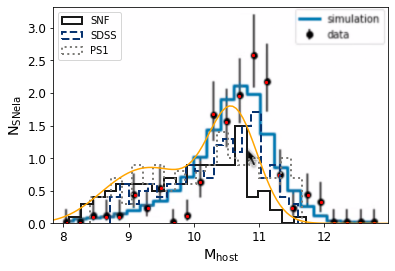

In [70]:
img = plt.imread("../../../Images/png/mass_hist_lowz_crop_zero.png")
fig, ax = plt.subplots()

Mmin = 7.85
Mmax = 12.98
Cmin = 0
Cmax = 170
f = 85.185

Mlist = [8.05, 8.25, 8.45, 8.65, 8.85,
         9.1, 9.3, 9.5, 9.7, 9.9,
         10.1, 10.3, 10.5, 10.7, 10.9,
         11.1, 11.3, 11.5, 11.75, 11.95,
         12.15, 12.35, 12.55, 12.76]

ax.scatter(Mlist,
           np.asarray([0, 0, 8, 8, 8,
                       37, 20, 46, 0, 10,
                       54, 143, 132, 166, 220,
                       185, 63, 20, 37, 28,
                       1, 0, 0, 0])/f,
          color='red', s=5)
ax.imshow(img, extent=[Mmin, Mmax, 0, 3.32])
          #[7.81, 12.94, 0, 170])

#ax.set_xlim([7.81, 12.94])
#ax.set_ylim([0, 170])

ax.tick_params(labelsize=12)

ax.set_xlabel(r'$\mathrm{M}_\mathrm{host}$', fontsize = 'x-large')
ax.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize="x-large")

def pdf_mass(x, fprompt):
    prompt_pdf = scipy.stats.norm.pdf(x,
                                      loc=9.41,
                                      scale=0.62)

    delay_pdf1 = scipy.stats.norm.pdf(x,
                                      loc=10.60,
                                      scale=0.38)

    delay_pdf2 = scipy.stats.norm.pdf(x,
                                      loc=8.74,
                                      scale=0.43)

    return(fprompt * prompt_pdf +
           (1-fprompt) * (0.90*delay_pdf1 + (1-0.90)*delay_pdf2))

def loglikepdf_mass(fprompt):
    return -2*np.sum(np.log(pdf_mass(Mlist, fprompt)))

def minimize_pdf_mass(print_level=0, **kwargs):
    '''Renvoie la meilleure valeur des paramètres'''
    m_tot = im.Minuit(loglikepdf_mass,
                      print_level=print_level,
                      pedantic=False,
                      fprompt=0.1,
                      **kwargs)
    migrad_out = m_tot.migrad()
    return(m_tot)

bestfit_mass = minimize_pdf_mass().values

xlin = np.linspace(7.85, 12.98, 100)
ax.plot(xlin,
        3*pdf_mass(xlin, bestfit_mass['fprompt']),
        color='orange')

ls = ['-', '--', ':']

for i, survey in enumerate(surveys[:3]):
    df_ncused = df_nc[df_nc['survey'] == survey]
    where = df_ncused['hostmass'] > 8
    df_cused = df_c[df_c['survey'] == survey]

    ax.hist(df_ncused[where].hostmass, bins=20,
            weights=[0.100 for i in range(len(df_ncused[where].hostmass))],
            histtype='step', lw=2, fill=False,
            zorder=1,
            edgecolor=colors[survey],
            facecolor=alphacolors(.5, survey),
            ls=ls[i], label=survey)
    
ax.legend(loc='upper left')

#ax.plot(x, x, '--', linewidth=5, color='firebrick')
#fig.savefig('../../../Images/png/mass_hist_lowz-fitted.png', bbox_inches='tight', dpi=600)

In [112]:
bestfit_mass['fprompt']

0.41157248447333517